In [1]:
%pip install chromadb scikit-learn matplotlib seaborn tqdm sentence-transformers

Note: you may need to restart the kernel to use updated packages.


# Import des Librairies

In [ ]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from demo_utils import batch_insert_chroma, query_db, apply_majority_vote
CREATE = False

# Chargement des datasets

Les datasets sont constitués de tickets de support IT issus d'un dataset public domain disponible [ici](https://www.kaggle.com/datasets/adisongoh/it-service-ticket-classification-dataset)

La répartition est définie ainsi :
- 1000 tickets pour le dataset de référence
- 2000 tickets pour le fine tuning
- \> 44 000 tickets à classifier

Ici, nous effectuons simplement la tâche de classification, nous chargeons donc simplement le dataset à labelliser (df_label) et le dataset de référence (df_class)

In [3]:
df_label = pd.read_csv("data/processed/eval_dataset.csv")
df_class = pd.read_csv("data/processed/reference_dataset.csv")

display(df_label.head())
display(df_class.head())


,Document,Topic_group
0,access to confluence wednesday pm confluence d...,Access
1,special request creation march pm special impo...,Hardware
2,amend ad amend ad urgent dear please kindly am...,Miscellaneous
3,wants to access documents friday wants review ...,Storage
4,access to storage to storage hi guys please sh...,Storage


,Document,Topic_group
0,role thursday october pm re ca la delegate la ...,Hardware
1,certificate problem sent friday march certific...,Hardware
2,local admin rights request rights hi please pr...,Storage
3,plug adapter plug adapter hello please provide...,Hardware
4,access to wednesday pm hello please allow writ...,HR Support


# Répartition de la donnée

Les graphiques ci dessous représentent la répoartition des classes sur le dataset à labelliser et le dataset de référence. On peut voir que les répartitions ont été gardées identiques pour simuler un cas réel, et que la disparité des données va peu à peu s'effacer en tant que problématique.

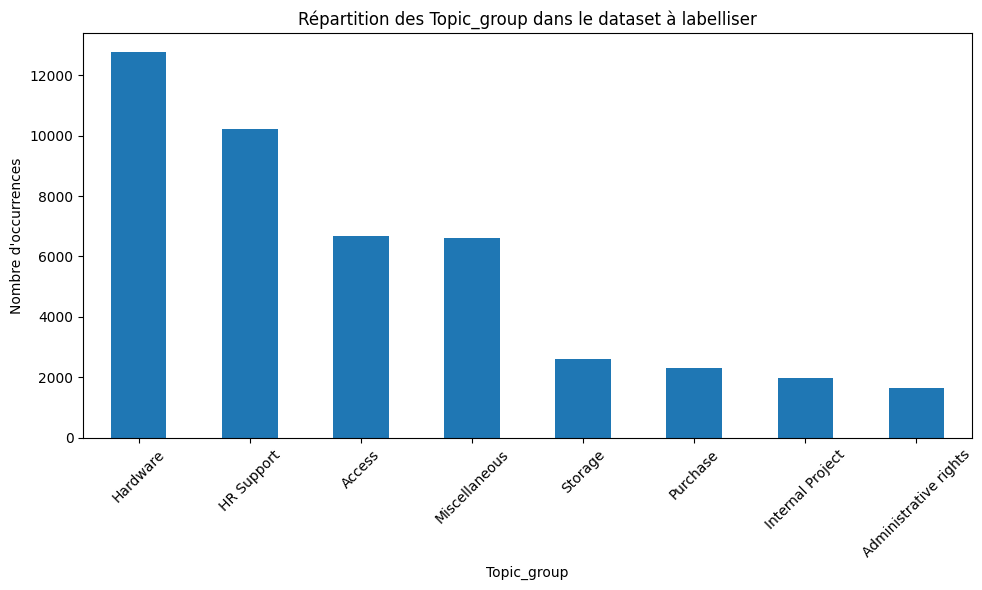

In [4]:
plt.figure(figsize=(10,6))
df_label['Topic_group'].value_counts().plot(kind='bar')
plt.title("Répartition des Topic_group dans le dataset à labelliser")
plt.xlabel("Topic_group")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

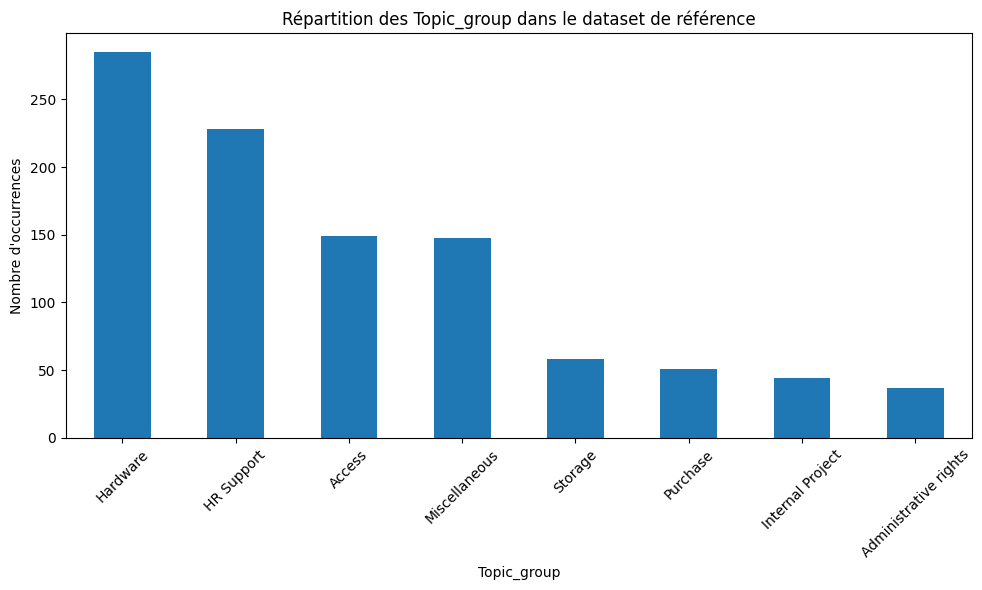

In [5]:
plt.figure(figsize=(10,6))
df_class['Topic_group'].value_counts().plot(kind='bar')
plt.title("Répartition des Topic_group dans le dataset de référence")
plt.xlabel("Topic_group")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Connexion à la base de données vectorielle

Ici, nous travaillons en local, donc nous levons le serveur à travers un dossier de persistance.

In [6]:
persist_dir="chromadb/"
client = chromadb.PersistentClient(path=persist_dir)

# Chargement du modèle par défaut

Nous créons tout d'abord 2 collections (labellisation et référence) avec comme modèle de vectorisation le modèle par défaut de chromaDB. Cela nous permettra de comparer les performances avec la version fine-tunée.

Beaucoup de clients ont des restrictions quant à l'IA générative et les modèles provenant d'hugging face. Ici nous utiliserons le modèle par défaut de ChromaDB téléchargé en local, mais chromaDB peut se charger de son téléchargement si vous ne spécifiez pas de paramètre "embedding_function" dans la création d'une collection. Votre contexte de travail doit bien sûr s'y prêter, et ne pas bloquer les téléchargements.

In [7]:
# Fonction d'embedding de base :
base_model = "models/all-MiniLM-L6-v2"
base_embedding = SentenceTransformerEmbeddingFunction(base_model)

In [8]:
# Insertion du dataset à labelliser dans ChromaDB
collection = client.get_or_create_collection(name="tickets_label", configuration ={"hnsw": {"space": "cosine"}}, embedding_function=base_embedding)

In [ ]:
if CREATE:
    all_ids = collection.get()["ids"]
    if all_ids:
        collection.delete(ids=all_ids)    
    documents = df_label['Document'].astype(str).tolist()
    metadatas = [{"Topic_group": tg} for tg in df_label['Topic_group'].astype(str)]
    ids = [str(index) for index in df_label.index]
    batch_insert_chroma(collection, documents, metadatas, ids, 1500)


Ajout dans ChromaDB: 100%|██████████| 30/30 [16:05<00:00, 32.18s/it]


In [10]:
# Création de la collection de référence pour la classification par similarité
collection_class = client.get_or_create_collection(name="tickets_class", configuration ={"hnsw": {"space": "cosine"}}, embedding_function=base_embedding)

In [ ]:

if CREATE:
    all_ids = collection_class.get()["ids"]
    if all_ids:
        collection_class.delete(ids=all_ids)
    documents_class = df_class['Document'].astype(str).tolist()
    metadatas_class = [{"Topic_group": tg} for tg in df_class['Topic_group'].astype(str)]
    ids_class = [str(i) for i in df_class.index]
    batch_insert_chroma(collection_class, documents_class, metadatas_class, ids_class, 1500)

Ajout dans ChromaDB: 100%|██████████| 1/1 [00:16<00:00, 16.05s/it]


In [12]:
# Requête de la première ligne pour test
first_id = str(df_label.index[0])
result = collection.get(ids=[first_id])
print(result)

{'ids': ['0'], 'embeddings': None, 'documents': ['access to confluence wednesday pm confluence dear please provide confluence thank leader'], 'uris': None, 'included': ['metadatas', 'documents'], 'data': None, 'metadatas': [{'Topic_group': 'Access'}]}


# Création de la collection fine-tunée

Puis nous chargeons le modèle fine-tuné sur les deux mêmes datasets. Chroma n'accepte qu'une fonction de vectorisation par collection et ne permet pas de la changer en cours de route, nous créons donc 2 nouvelles collections. Sur des systèmes type base PostgreSQL équipées d'un plugin (PGvector par ex.) il est possible d'avoir plusieurs colonnes de vecteurs, et donc de gérer facilement plusieurs fonctions d'embedding sur une même table, puisque reposant sur le script d'insertion des données.

In [13]:
#Fonction d'embedding fine-tuné
ft_model = "models/fine_tuned_ticket_embedder_v5"
ft_embedding = SentenceTransformerEmbeddingFunction(ft_model)

In [17]:
# Insertion du dataset à labelliser dans ChromaDB avec le modèle fine tuné
ft_collection = client.get_or_create_collection(name="ft_tickets_label_v5", configuration ={"hnsw": {"space": "cosine"}}, embedding_function=ft_embedding)
if CREATE:
    all_ids = ft_collection.get()["ids"]
    if all_ids:
        ft_collection.delete(ids=all_ids)
    batch_insert_chroma(ft_collection, documents, metadatas, ids, batch_size=1500, desc="Ajout tickets_label")

# Idem pour la collection de référence 
ft_collection_class = client.get_or_create_collection(name="ft_tickets_class_v5", configuration ={"hnsw": {"space": "cosine"}}, embedding_function=ft_embedding)
if CREATE:
    all_ids = ft_collection_class.get()["ids"]
    if all_ids:
        ft_collection_class.delete(ids=all_ids)
    batch_insert_chroma(ft_collection_class, documents_class, metadatas_class, ids_class, batch_size=1500, desc="Ajout tickets_class")

Ajout tickets_class: 100%|██████████| 1/1 [00:13<00:00, 13.59s/it]


# Classification des messages

Nous utilisons le concept de similarité vectorielle pour classifier les messages. Ici, nous utilisons comme fonction de comparaison la similarité cosine qui, située proche de 0 signifie une grande différence tandis que proche de 1, elle indique une forte ressemblance. Le moteur de chromadb se chargera de la recherche pour nous, inutile de recoder une fonction de comparaison. Cependant, au lieu de comparer les vecteurs à classifier à une classe nous les comparons aux messages de référence à partir desquels nous extrairons la classe depuis les métadonnées. Cette approche présente une meilleure performance que la comparaison brute à la classe en elle même. (cf figure ci-contre et résultats en dessous)
![Figure 1 - résultats de comparaison à la classe seule](imgs/cm_raw.png)

In [18]:
# Classification par similarité : pour chaque ticket, retourne la classe du message le plus proche et le top 10
print(collection.count())
embeddings = collection.get(include=["embeddings"])['embeddings']
ft_embeddings = ft_collection.get(include=["embeddings"])["embeddings"]
results =[]
ft_results = []
labels = df_class['Topic_group'].index.values.astype(str).tolist()
batch_size = 1000

def process_batch(batch, start_idx, ft):
    if ft:
        query_collection = ft_collection_class
    else:
        query_collection = collection_class
    return query_db(batch, start_idx, query_collection, df_label, ft)

tasks = []

with ThreadPoolExecutor(max_workers=8) as executor:
    for i in range(0, len(embeddings), batch_size):
        batch = embeddings[i:i+batch_size]
        tasks.append(executor.submit(process_batch, batch, i, False))

    for i in range(0, len(ft_embeddings), batch_size):
        batch = ft_embeddings[i:i+batch_size]
        tasks.append(executor.submit(process_batch, batch, i, True))

    for future in tqdm(as_completed(tasks), total=len(tasks), desc="Classification"):
        batch_result = future.result()
        if batch_result and isinstance(batch_result[0], dict) and batch_result[0].get('ft', False):
            ft_results.extend(batch_result)
        else:
            results.extend(batch_result)

44837


Classification: 100%|██████████| 90/90 [00:14<00:00,  6.37it/s]


In [19]:
# Récupération des vraies classes et des classes prédites
res_df = pd.DataFrame(results).set_index("ticket_id")
ft_res_df = pd.DataFrame(ft_results).set_index("ticket_id")
y_true = res_df["true_class"]
y_pred = res_df["closest_class"]
ft_y_true = ft_res_df["true_class"]
ft_y_pred = ft_res_df["closest_class"]

# Point culture datascience : precision, recall, accuracy et f1-score
Sur les tâches de classification nous utilisons 4 grandes métriques pour évaluer les performances:

- ### La précision :
La précision cherche à valoriser la bonne prédiction sans faux positifs (valeurs "sur"détectées). Par exemple, un système de credit scoring préfèrera maximiser cette métrique pour ne pas valider à tort de crédit.

- ### Le rappel (recall):
Le recall cherche à valoriser la bonne prédiction sans faux négatifs (valeurs non détectées). Par exemple, en médecine, on préfère une fausse alerte, que ne pas détecter un cas.

- ### Le F1-Score :
Moyenne harmonique des deux valeurs précédentes, elle représente un cas où l'on recherche un équilibre entre ces situations.

- ### L'exactitude (accuracy):
L'exactitude est une métrique qui mesure le taux de réponse correctes. Utile dans des cas où les classes sont équilibrées et où toutes les erreurs ont le même coût.

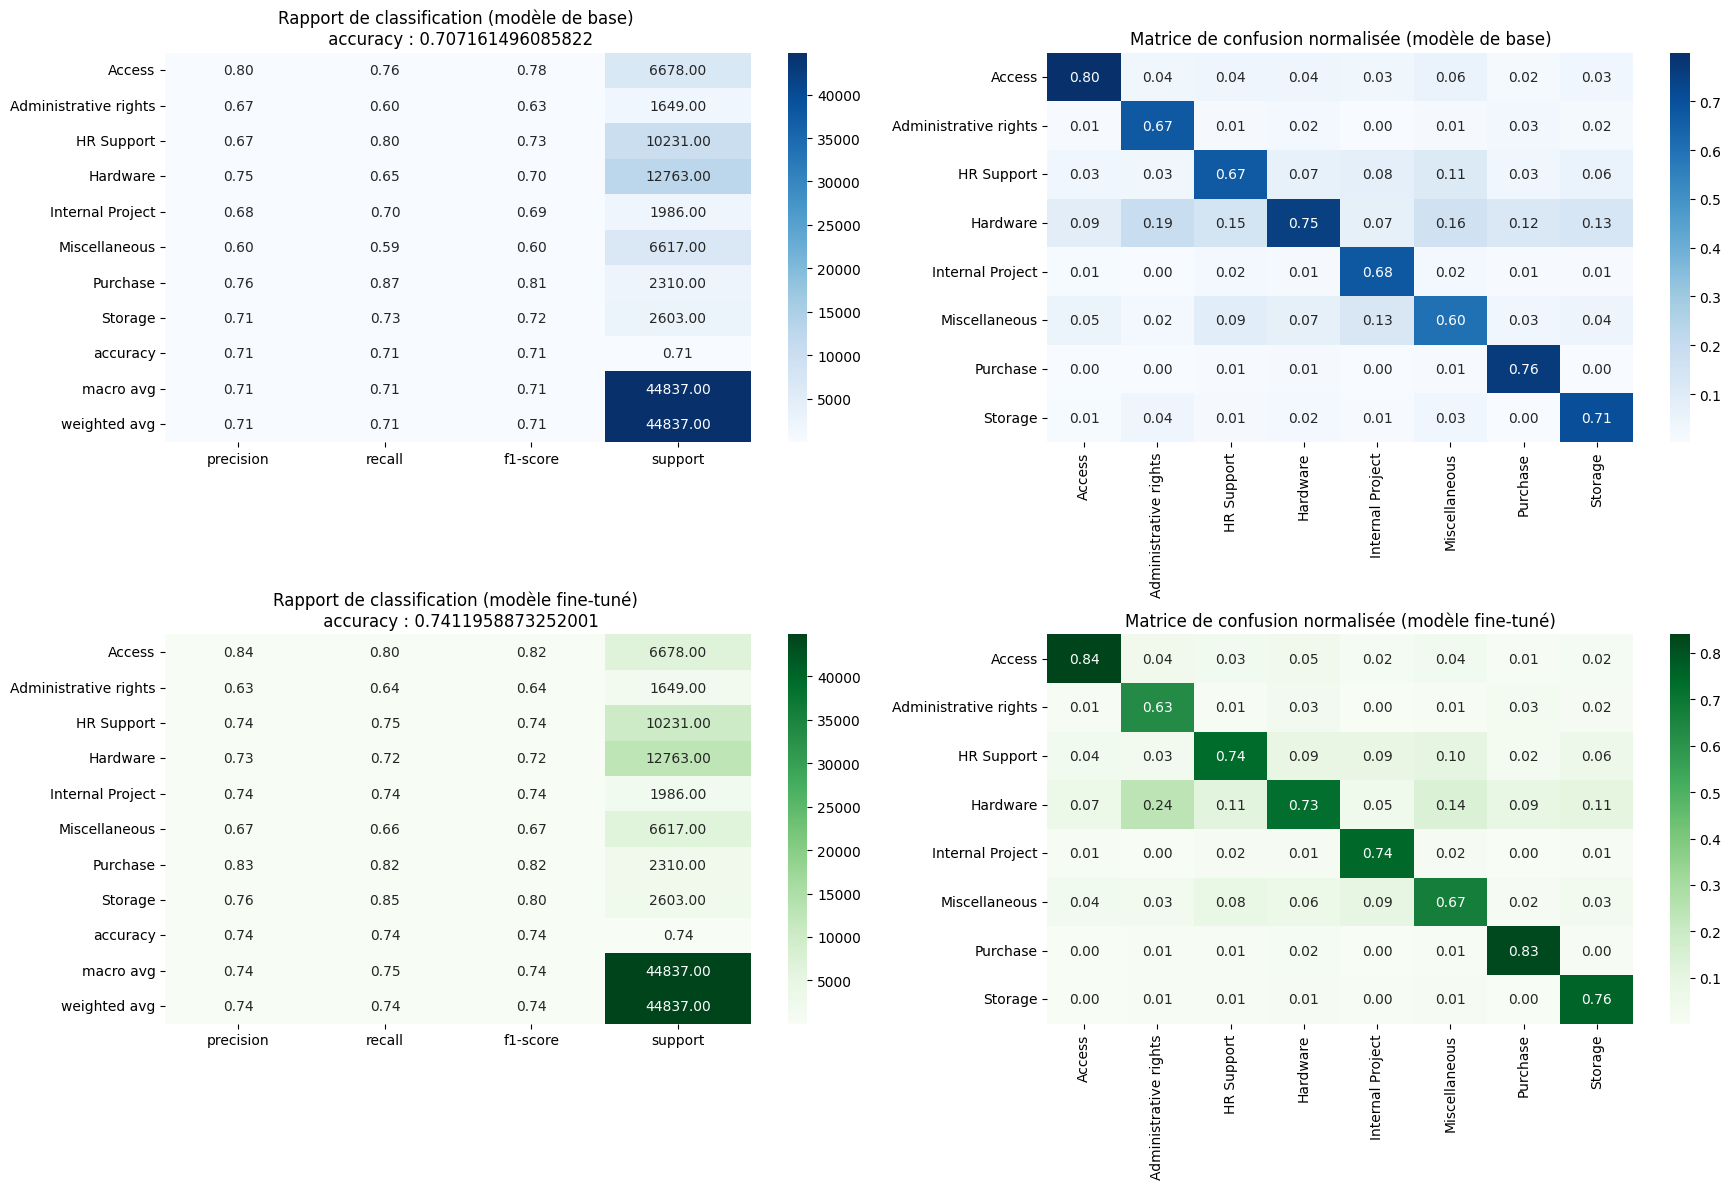

In [ ]:
labels = sorted(df_label['Topic_group'].unique())

# Rapports sous forme de dict
report_y_dict = classification_report(y_true, y_pred, labels=labels, output_dict=True)
report_ft_dict = classification_report(ft_y_true, ft_y_pred, labels=labels, output_dict=True)

# Convertir en DataFrame
report_y_df = pd.DataFrame(report_y_dict).transpose()
report_ft_df = pd.DataFrame(report_ft_dict).transpose()

# Matrices de confusion
cm_y = confusion_matrix(y_true, y_pred, labels=labels, normalize='pred')
cm_ft = confusion_matrix(ft_y_true, ft_y_pred, labels=labels, normalize='pred')

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Heatmap du rapport (modèle de base)
sns.heatmap(report_y_df.iloc[:, :], annot=True, fmt=".2f", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title("Rapport de classification (modèle de base)")

# Matrice de confusion (modèle de base)
sns.heatmap(cm_y, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels, ax=axes[0, 1])
axes[0, 1].set_title("Matrice de confusion normalisée (modèle de base)")

# Heatmap du rapport (modèle fine-tuné)
sns.heatmap(report_ft_df.iloc[:, :], annot=True, fmt=".2f", cmap="Greens", ax=axes[1, 0])
axes[1, 0].set_title("Rapport de classification (modèle fine-tuné)")

# Matrice de confusion (modèle fine-tuné)
sns.heatmap(cm_ft, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=labels, yticklabels=labels, ax=axes[1, 1])
axes[1, 1].set_title("Matrice de confusion normalisée (modèle fine-tuné)")

plt.tight_layout()
plt.show()



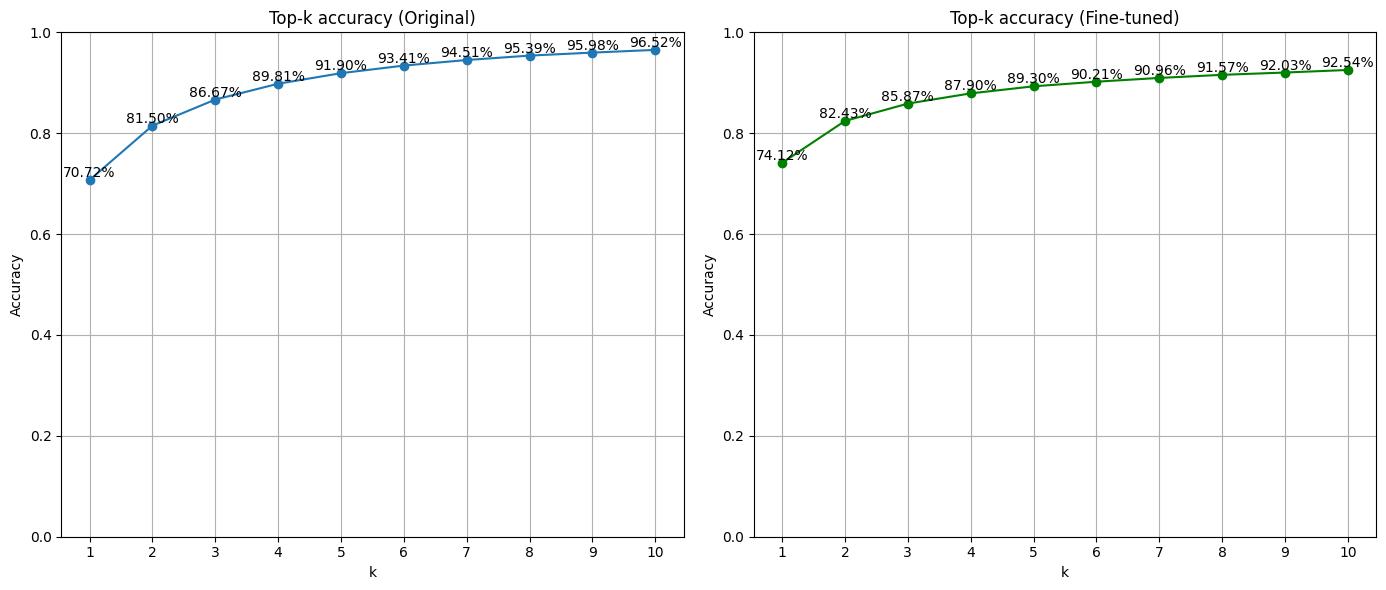

In [21]:
def top_k_accuracy(results, k):
    return sum([r['true_class'] in r['top10_classes'][:k] for r in results]) / len(results)

top_ks = 10
scores = [top_k_accuracy(results, k+1) for k in range(top_ks)]
ft_scores = [top_k_accuracy(ft_results, k+1) for k in range(top_ks)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(range(1, top_ks+1), scores, marker='o')
axes[0].set_xticks(range(1, top_ks+1))
axes[0].set_ylim(0, 1)
axes[0].set_title("Top-k accuracy (Original)")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Accuracy")
for k, score in zip(range(1, top_ks+1), scores):
    axes[0].text(k, score, f"{score:.2%}", ha='center', va='bottom')
axes[0].grid()

axes[1].plot(range(1, top_ks+1), ft_scores, marker='o', color='green')
axes[1].set_xticks(range(1, top_ks+1))
axes[1].set_ylim(0, 1)
axes[1].set_title("Top-k accuracy (Fine-tuned)")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Accuracy")
for k, score in zip(range(1, top_ks+1), ft_scores):
    axes[1].text(k, score, f"{score:.2%}", ha='center', va='bottom')
axes[1].grid()

plt.tight_layout()
plt.show()


# Utilisation du vote majoritaire

Afin d'améliorer les résultats nous allons procéder à un "vote majoritaire" parmi les 10 premières classes. Les votes seront pondérés par la valeur de similarité cosine afin d'éviter que les classes les plus basses ne puisse bruiter le résultat.

In [22]:
# Appliquer pour les deux ensembles
votes_df, results_df = apply_majority_vote(results)
ft_votes_df, ft_results_df = apply_majority_vote(ft_results)


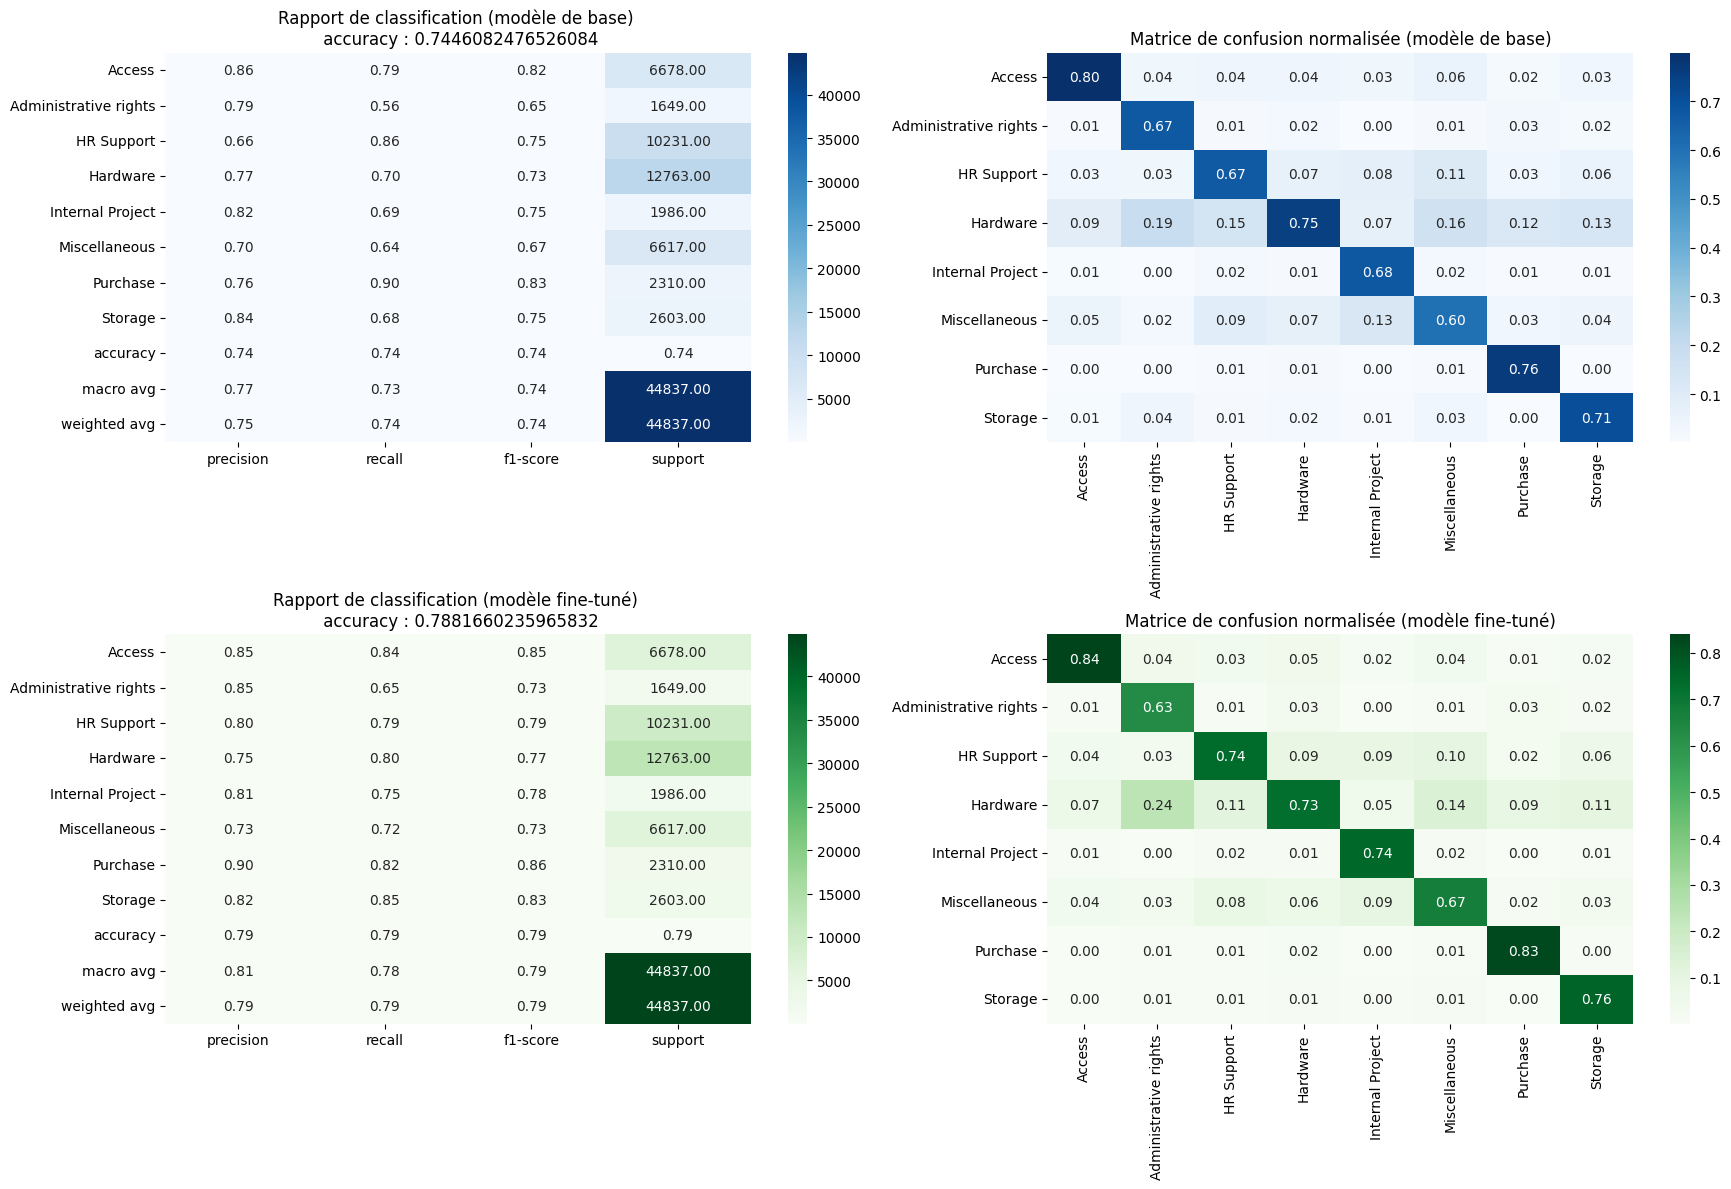

In [ ]:
# Rapports sous forme de dict
report_y_dict = classification_report(results_df['true_class'], results_df['majority_vote'], labels=labels, output_dict=True)
report_ft_dict = classification_report(ft_results_df['true_class'], ft_results_df['majority_vote'], labels=labels, output_dict=True)

# Convertir en DataFrame
report_y_df = pd.DataFrame(report_y_dict).transpose()
report_ft_df = pd.DataFrame(report_ft_dict).transpose()

# Matrices de confusion
cm_y = confusion_matrix(y_true, y_pred, labels=labels, normalize='pred')
cm_ft = confusion_matrix(ft_y_true, ft_y_pred, labels=labels, normalize='pred')

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Heatmap du rapport (modèle de base)
sns.heatmap(report_y_df.iloc[:, :], annot=True, fmt=".2f", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title("Rapport de classification (modèle de base)")

# Matrice de confusion (modèle de base)
sns.heatmap(cm_y, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels, ax=axes[0, 1])
axes[0, 1].set_title("Matrice de confusion normalisée (modèle de base)")

# Heatmap du rapport (modèle fine-tuné)
sns.heatmap(report_ft_df.iloc[:, :], annot=True, fmt=".2f", cmap="Greens", ax=axes[1, 0])
axes[1, 0].set_title("Rapport de classification (modèle fine-tuné)")

# Matrice de confusion (modèle fine-tuné)
sns.heatmap(cm_ft, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=labels, yticklabels=labels, ax=axes[1, 1])
axes[1, 1].set_title("Matrice de confusion normalisée (modèle fine-tuné)")

plt.tight_layout()
plt.show()